In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from scipy import integrate
from scipy.stats import shapiro, ttest_ind, levene
from scipy.ndimage import gaussian_filter1d
from statsmodels.stats import oneway
from annotator_amide_abs import annotator_zoom
%matplotlib widget

In [2]:
wave_no = pd.read_csv('../mdi_optimization/cleaned_csvs/wave_no.csv')

kgy0 = pd.read_csv('../mdi_optimization/cleaned_csvs/48_scans.csv').drop(columns=['wave_no'])
kgy5 = pd.read_csv('../irradiated_analysis/5kgy/5kgy_sn48.csv')
kgy10 = pd.read_csv('../irradiated_analysis/10kgy/10kgy_sn48.csv')

for df in [kgy0, kgy5, kgy10]:
    df['average'] = df.iloc[:,:].mean(axis=1)

Broad Amide Region Area Computation

In [11]:
wave_amide = wave_no['wave_no'].iloc[1080:1366]
amide_area_df = pd.DataFrame()

for df, group_name in zip([kgy0, kgy5, kgy10], ['0kGy_amide_area', '5kGy_amide_area', '10kGy_amide_area']):
    area_group = []
    for samp in df.columns[0:6]:
        spec_amide = df[samp][1080:1366]
        amide_area = integrate.simpson(np.flip(spec_amide), x=np.flip(wave_amide))
        area_group.append(amide_area)

    amide_area_df[group_name] = list(area_group)

In [16]:
kgy_amide_area = [amide_area_df[col] for col in amide_area_df.columns]

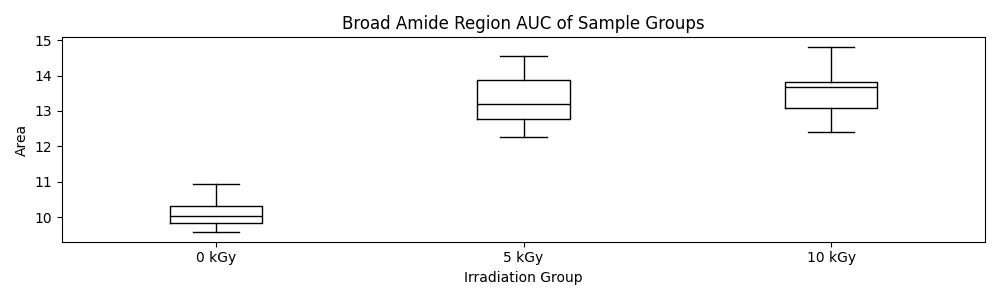

In [6]:
amide_box, axis = plt.subplots(1,1, figsize=(10,3))

axis.boxplot(x=kgy_amide_area, medianprops={'color':'black'})
axis.set(xticklabels=['0 kGy', '5 kGy', '10 kGy'],
         xlabel='Irradiation Group',
         ylabel='Area',
         title='Broad Amide Region AUC of Sample Groups')

amide_box.tight_layout()

Test for Normality

In [7]:
alpha=0.05

Test for Homogeneity of Variances

In [8]:
for group, area in zip(['0kGy_amide_area', '5 kGy_amide_area', '10 kGy_amide_area'], kgy_amide_area):
    s_stat, s_p = shapiro(area, nan_policy='omit')

    normal = True
    if s_p < alpha: normal = False

    print(f'Scan No. {group} {normal=} {s_stat=} {s_p=} ')

Scan No. 0kGy_amide_area normal=True s_stat=np.float64(0.953214225555281) s_p=np.float64(0.766212664380058) 
Scan No. 5 kGy_amide_area normal=True s_stat=np.float64(0.9661111632530114) s_p=np.float64(0.8653670837025791) 
Scan No. 10 kGy_amide_area normal=True s_stat=np.float64(0.9636905695784804) s_p=np.float64(0.8476824020681082) 


In [9]:
l_stat, l_p = levene(*kgy_amide_area, nan_policy='omit')
homo_var = False
if l_p < alpha: sig_dif = True

print(f'{homo_var=} {l_stat=} {l_p=}')

homo_var=False l_stat=np.float64(0.992292408907315) l_p=np.float64(0.3937970234989848)


Welch's ANOVA

In [16]:
w_stat, w_p = oneway.anova_oneway(kgy_amide_area, use_var='unequal')
sig_dif = False
if w_p < alpha: sig_dif = True

print(f'{sig_dif=} {w_stat=} {w_p=}')
print(f"degrees of freedom = {oneway.anova_oneway(kgy_amide_area, use_var='unequal').df}")

sig_dif=True w_stat=np.float64(52.68105379641474) w_p=np.float64(8.864331276619592e-06)
degrees of freedom = (2.0, np.float64(9.2408317058521))


Pairwise Comparison (t-test)

In [37]:
print('5 v 10')
t_stat, t_p = ttest_ind(amide_area_df['5kGy_amide_area'], amide_area_df['10kGy_amide_area'])
sig_dif = False
if t_p < alpha: sig_dif = True
print(f'{sig_dif=} {t_stat=} {t_p=}')


print('\n0 v 5')
t_stat, t_p = ttest_ind(amide_area_df['0kGy_amide_area'], amide_area_df['5kGy_amide_area'])
sig_dif = False
if t_p < alpha: sig_dif = True
print(f'{sig_dif=} {t_stat=} {t_p=}')


print('\n0 v 10')
t_stat, t_p = ttest_ind(amide_area_df['0kGy_amide_area'], amide_area_df['10kGy_amide_area'])
sig_dif = False
if t_p < alpha: sig_dif = True
print(f'{sig_dif=} {t_stat=} {t_p=}')

5 v 10
sig_dif=False t_stat=np.float64(-0.49445902050968293) t_p=np.float64(0.6316636754474607)

0 v 5
sig_dif=True t_stat=np.float64(-7.955411079073046) t_p=np.float64(1.2365325955729616e-05)

0 v 10
sig_dif=True t_stat=np.float64(-8.795652859611677) t_p=np.float64(5.084750707950433e-06)


Broad Amide Region Area Visualization

In [19]:
amide_area_means = amide_area_df.mean()

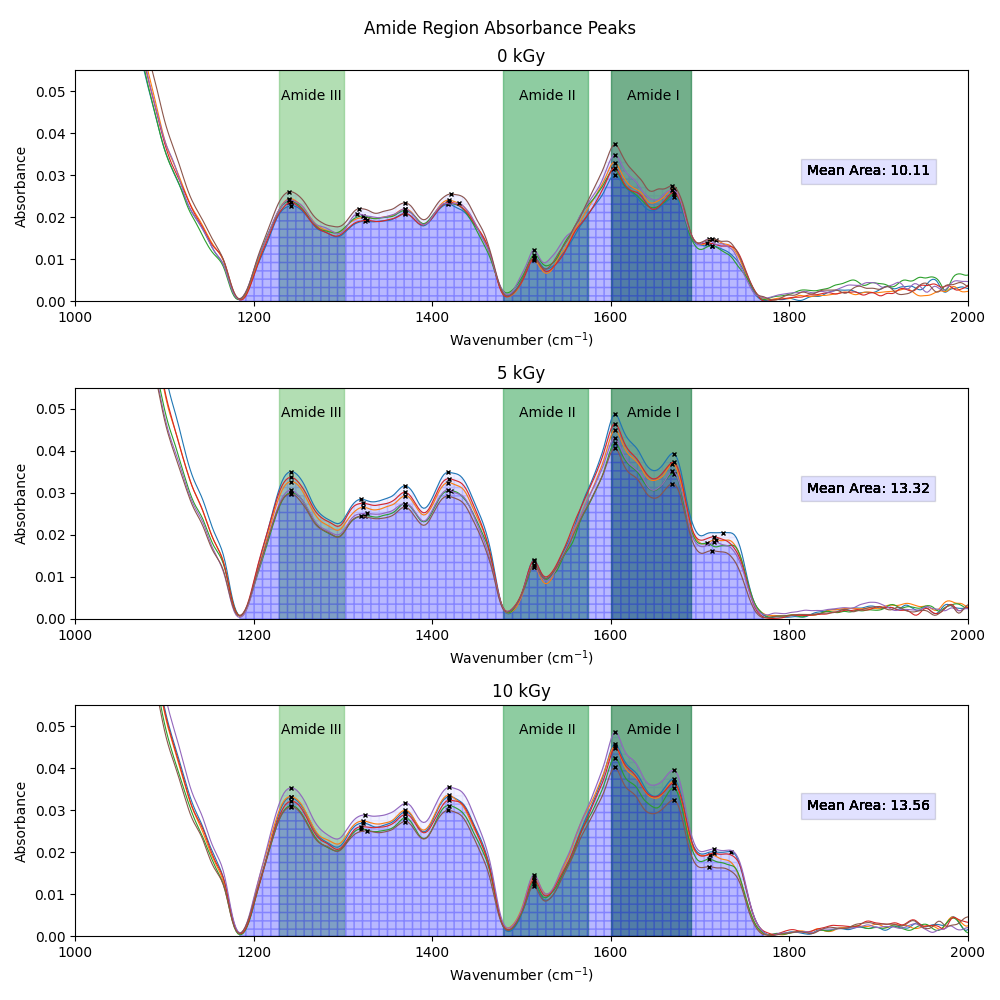

In [59]:
fig, axes = plt.subplots(3,1, figsize=(10,10))
fig.suptitle('Amide Region Absorbance Peaks')

for axis, group, mean, group_name in zip(axes, [kgy0, kgy5, kgy10], amide_area_means, ['0 kGy', '5 kGy', '10 kGy']):
    annotator_zoom(axis)

    for samp in group.columns[0:6]:
        spec = group[samp]

        sigma=2
        spec = gaussian_filter1d(spec, sigma)

        peaks, params = find_peaks(spec, distance=18)

        axis.plot(wave_no, spec, linewidth=0.8)
        axis.text(1820, 0.03, f'Mean Area: {mean:.2f}', fontsize=10, bbox=dict(facecolor='blue', alpha=0.02))
        axis.fill_between(wave_no['wave_no'].iloc[1080:1366], spec[1080:1366], 0, color='blue', alpha=0.05, hatch='++') # Analysis region
        axis.set(title=f"{group_name}",
                 xlabel='Wavenumber (cm$^{-1}$)',
                 ylabel='Absorbance')

        for peak in peaks:
            if 1180 <= wave_no.iloc[peak,:].item() <= 1780:
                axis.plot(wave_no.iloc[peak,:], spec[peak], 'x', markersize=3.5, markeredgewidth=1, color='black')

fig.tight_layout()